Modifying Question Paper

In [1]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xlwt

     ------------------------------------ 100.0/100.0 kB 954.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [103]:
import xlwt

from commonfunctions import *
import numpy as np
import pandas as pd
import cv2
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.transform import resize


# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


get BinaryImg:

input: 

grey img

threshold

output:

binary image

In [4]:
def getBinaryImg(img, thresh):

    binary_img = img.copy()
    binary_img[binary_img > thresh] = 1
    binary_img[binary_img <= thresh] = 0
    return binary_img
#show_images([getBinaryImg(io.imread('2/1.jpg'), 0.7)])

getClosedImg:

input:

binary img - window size

output:

closed image

In [5]:
def getClosedImg(img, win_size):
    closed_img = binary_dilation(binary_erosion(img, footprint=win_size), footprint=win_size)
    #show_images([closed_img])
    return closed_img

#binary = getBinaryImg(io.imread('2/1.jpg'), 0.7)
#win_size = np.ones((3, 3), dtype=int)
#show_images([getClosedImg(binary,win_size)])

getAspectRatioContour

gets image contour depending on aspect ratio 

In [6]:
def getAspectRatioContour(img, thresh = 0.7, win_size =  np.ones((2, 2), dtype=int), lower_aspect = 6, upper_aspect = 10):
    binary_img = getBinaryImg(img, thresh)
    
    closed_img = getClosedImg(binary_img, win_size)
    
    #show_images([closed_img])
    
    contour = find_contours(closed_img, 0.8)
    #print(contour)
    bounding_rects = []
    
    for rect in contour:
        x_min = rect[:, 1].min()
        x_max = rect[:, 1].max()
        y_min = rect[:, 0].min()
        y_max = rect[:, 0].max()
        
        aspect_ratio = (x_max - x_min) / (y_max - y_min) 
        area = (x_max - x_min) * (y_max - y_min) 
        if (lower_aspect < aspect_ratio < upper_aspect) and (300 < area < 9000):
            bounding_rects.append([int(x_min), int(x_max), int(y_min), int(y_max)])
    bounding_rects = sorted(bounding_rects, key = lambda item: (item[2] + 2*item[0]))
    return bounding_rects


getRectContour:

input: grey img, threshold, window size

output: array of contours with area as the first element and sorted according to area

In [7]:
def getRectContour(img, thresh = 0.7, win_size =  np.ones((2, 2), dtype=int), inverse = 0):
    binary_img = getBinaryImg(img, thresh)

    closed_img = getClosedImg(binary_img, win_size)
    
    contour = find_contours(closed_img, 0.8)

    bounding_rects = []
    area = []
    
    for rect in contour:
        x_min = rect[:, 1].min()
        x_max = rect[:, 1].max()
        y_min = rect[:, 0].min()
        y_max = rect[:, 0].max()
        
        area = (x_max - x_min)*(y_max - y_min)
        
        aspect_ratio = (x_max - x_min) / (y_max - y_min) 
        
        if aspect_ratio > 1:
            bounding_rects.append([int(area),int(x_min), int(x_max), int(y_min), int(y_max)])
    
    bounding_rects = sorted(bounding_rects, reverse = True)


    return bounding_rects


getCVRectContour

input: grey img, upper thresh, lower thresh, sigma, windowsize

output: array of contours sorted according to area

In [117]:
def getCVRectContour(img, ut = 150,lt = 100,kernel = 3, win_size =  np.ones((3, 3), dtype=int)):

    img_blur = cv2.GaussianBlur(img, (kernel, kernel), 7)

    img_canny = cv2.Canny(img,lt,ut) 

    img_dial = cv2.dilate(img_canny, win_size, iterations=2)
    img_closed = cv2.erode(img_dial, win_size, iterations=1)
    
    #show_images([img_blur, img_closed])
    contours, heirarchy = cv2.findContours(img_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    bounding_rects = []
    
    for rect in contours:
        area = cv2.contourArea(rect)
        #print(area)
        perimeter = cv2.arcLength(rect, True)
        points = cv2.approxPolyDP(rect, 0.02*perimeter, True)
        #print(points)
        
        if (len(points) == 4) and (area > 50):
            bounding_rects.append(rect)
            
    bounding_rects = sorted(bounding_rects, key = cv2.contourArea, reverse = True)    
    
    return bounding_rects
    
image = cv2.cvtColor(io.imread('1/4.jpg'), cv2.COLOR_BGR2GRAY)

c = getCVRectContour(image)



In [118]:
def getAspectCornerPoints(contour, i,img):
    c = contour[i]

    points = np.array([[c[0], c[2]],
                      [c[1], c[2]],
                      [c[1], c[3]],
                      [c[0], c[3]]])
    
    #grey_img = img.copy()
    #plt.plot([points[0][0], points[1][0]], [points[0][1], points[1][1]], color = "black", linewidth = 1)
    #plt.plot([points[1][0], points[2][0]], [points[1][1], points[2][1]], color = "black", linewidth = 1)
    #plt.plot([points[2][0], points[3][0]], [points[2][1], points[3][1]], color = "black", linewidth = 1)
    #plt.plot([points[3][0], points[0][0]], [points[3][1], points[0][1]], color = "black", linewidth = 1)
    #plt.imshow(grey_img)
    #plt.show()
    
    
    return points

getCVCornerPoints

input: CVcontour

output: cornerpoints

In [119]:
def getCVCornerPoints(contour):
    perimeter = cv2.arcLength(contour, True)
    points = cv2.approxPolyDP(contour, 0.02*perimeter, True)
    return points
p = getCVCornerPoints(c[0])


getCornerPoints

input: contour, index of the largest contour area, image

output: corner points

In [120]:
def getCornerPoints(contour, i,img):
    c = contour[i][1:5]
    #print(c)
    points = np.array([[c[0], c[2]],
                      [c[1], c[2]],
                      [c[1], c[3]],
                      [c[0], c[3]]])
    #print(img)
    grey_img = img.copy()
    #plt.plot([points[0][0], points[1][0]], [points[0][1], points[1][1]], color = "black", linewidth = 1)
    #plt.plot([points[1][0], points[2][0]], [points[1][1], points[2][1]], color = "black", linewidth = 1)
    #plt.plot([points[2][0], points[3][0]], [points[2][1], points[3][1]], color = "black", linewidth = 1)
    #plt.plot([points[3][0], points[0][0]], [points[3][1], points[0][1]], color = "black", linewidth = 1)
    #plt.imshow(grey_img)
    #plt.show()
    

    
    #show_images([grey_img])
    #print(x1)
    return points



   

getOrderedCornerPoints

input: points

output: ordered points

In [121]:
def getOrderedCornerPoints(points):
    points = points.reshape((4,2))
    points_ordered = np.zeros((4,1,2), np.int32)
    s = points.sum(1)
    diff = np.diff(points, axis = 1)
    #print(points)
    points_ordered[0] = points[np.argmin(s)]
    points_ordered[1] = points[np.argmin(diff)]
    points_ordered[2] = points[np.argmax(diff)]
    points_ordered[3] = points[np.argmax(s)]
    #print(points_ordered)
    return points_ordered

widthImg = image.shape[0]
heightImg = image.shape[1]

points = getOrderedCornerPoints(p)

p2 = np.float32([[0,0], [widthImg,0], [0,heightImg], [widthImg, heightImg]])
p1 = np.float32(points)

img = cv2.getPerspectiveTransform(p1, p2)
img_warp = cv2.warpPerspective(image,img, (widthImg, heightImg))
img_warp = resize(img_warp, (800, 1000))
#show_images([img_warp])
#print(img_warp)

getIDRegion:

input: warped image - index depending on size of ID

output: ID image

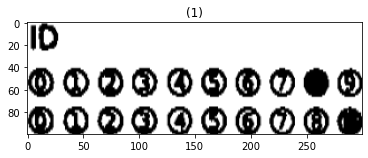

In [124]:
def getIDRegion(img, index = 1):
    #img[img > 0.7] = 1
    #img[img <= 0.7] = 0
    i = img.copy()
    i[i > 0.65] = 1
    i[i <= 0.65] = 0
    i = i[0:250, 80:560]

    win_size = np.ones((18, 42), dtype=int)
    
    c = getRectContour(i, thresh = 0.7, win_size =  win_size)
    p = getCornerPoints(c, index,i)
    p_ordered = getOrderedCornerPoints(p)
    p2 = np.float32([[0,0], [300,0], [0,100], [300, 100]])
    p1 = np.float32(p_ordered)
    
    ID_img = cv2.getPerspectiveTransform(p1, p2)
    ID_warp = cv2.warpPerspective(i,ID_img, (300, 100))
    
    return ID_warp
        
ID = getIDRegion(img_warp, index = 2)
show_images([ID])

getQuestionRegion

In [125]:
def getQuestionRegion(img, index = 1, mcq = 2):

    I = img.copy()
    I[I > 0.55] = 1
    I[I <= 0.55] = 0

    if mcq == 2:
        win_size = np.ones((3, 15), dtype=int)
        c = getAspectRatioContour(I, thresh = 0.5, win_size =  win_size, lower_aspect = 3.5, upper_aspect = 4.5)
    elif mcq == 3:
        win_size = np.ones((7, 20), dtype=int)
        c = getAspectRatioContour(I, thresh = 0.5, win_size =  win_size, lower_aspect = 5.5, upper_aspect = 7)
    elif mcq == 4:
        win_size = np.ones((2, 20), dtype=int)
        c = getAspectRatioContour(I, thresh = 0.5, win_size =  win_size, lower_aspect = 7, upper_aspect = 10)
    elif mcq == 5:
        win_size = np.ones((4, 20), dtype=int)
        c = getAspectRatioContour(I, thresh = 0.5, win_size =  win_size, lower_aspect = 10, upper_aspect = 20)
    #print(c)
    p = getAspectCornerPoints(c, index, I)
    
    p_ordered = getOrderedCornerPoints(p)
    
    p2 = np.float32([[0,0], [300,0], [0,100], [300, 100]])
    p1 = np.float32(p_ordered)
    
    Q_img = cv2.getPerspectiveTransform(p1, p2)
    Q_warp = cv2.warpPerspective(I,Q_img, (300, 100))
    
    #show_images([Q_warp])
    return Q_warp

Q = getQuestionRegion(img_warp, index = 0, mcq = 3)

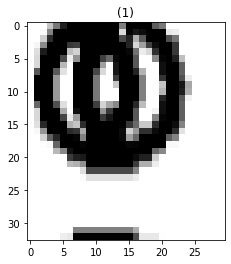

In [126]:
def splitrows(img, rowsnum):
    rows=[]
    Rsections=(100/(rowsnum+1))
    extra=Rsections/3
    extra=int(extra)
    Rsections=int(Rsections)
    Rbegin=int(Rsections+extra)
    Rend=int(Rbegin+Rsections)
    
    for i in range (rowsnum):
        rows.insert(i,img[Rbegin:Rend, :])
        Rbegin=Rend
        Rend=Rbegin+Rsections
    return rows

def splitcolumns(img):
    columns=[]
    sections=30
    begin=0
    end=begin+sections
    
    for i in range (10):
        columns.insert(i,img[:,begin:end])
        begin=end
        end=begin+sections
    return columns


def getbubble(img,rowsnum):
    bubbles=[]
    j=0
    k=0
    for i in range (rowsnum*10):
        IDrows = splitrows(img,rowsnum)
        IDrow = IDrows[j]
        IDcolumns = splitcolumns(IDrow)
        IDcolumn = IDcolumns[k]
        bubbles.insert(i,IDcolumn)
        k=k+1
        if (k>9):
            j=j+1
            k=0
    return bubbles


rowsnum =2
IDbubbles = getbubble(ID,rowsnum)
bubblenum = IDbubbles[0]
show_images([bubblenum])

In [127]:
def getID(rowsnum, IDbubbles):
    countC=0
    countR=0
    errorID=0
    sumarray=[]
    avgid=[]
    errorarr=[]
    sumID=0
    i=0
    pixelval=np.zeros((rowsnum,10))
    for images in IDbubbles:
        totalpixels=cv2.countNonZero(images)
        pixelval[countR][countC]=totalpixels
        sumID=sumID+totalpixels
        countC+=1
        if(countC == 10):
            sumarray.insert(i,sumID)
            sumID=0
            countR+=1
            countC=0
            i+=1
    
    for i in range (rowsnum):
        avgid.insert(i,int(sumarray[i]/10))
        errorarr.insert(i,int(sumarray[i]/120))
    
    #print(pixelval)
    #print(avgid)
    
    for j in range (rowsnum):
        for i in range (10):
            if(pixelval[j][i]<(avgid[j]-errorarr[j])):
                errorID=errorID+1
                
    if errorID>(rowsnum):
        print("wrong ID")
    
    arrindex=[]
    index=[]
    
    for x in range (0,rowsnum):
        arr=pixelval[x]
        index=np.where(arr==np.amin(arr))
        arrindex.append(index[0][0])
    

    return arrindex

ID = getID(rowsnum, IDbubbles)
print(ID)

[8, 9]


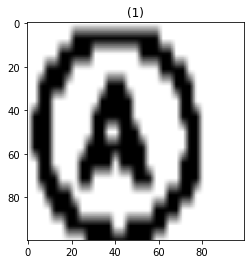

In [128]:
def splitQcolumns(img, colsnum):
    cols=[]
    Csections=(300/(colsnum))
    Csections=int(Csections)
    Cbegin=0
    Cend=Cbegin+Csections
    
    for i in range (colsnum):
        cols.insert(i,img[:, Cbegin:Cend])
        Cbegin=Cend
        Cend=Cbegin+Csections
    return cols

colsnum=3
columns=splitQcolumns(Q,colsnum)
column=columns[0]
show_images([column])

In [129]:
my_data = np.loadtxt('1.txt', delimiter=",", unpack=True)
list2= my_data[:]
print(list2)

[1. 2. 3. 3. 2. 1. 1. 2. 3. 3. 3. 2. 2.]


In [130]:
def getQanswer(colsnum,columns):   
    countC=0
    countR=0
    error=0
    summ=0
    pixelval=np.zeros((1,colsnum))
    for images in columns:
        totalpixels=cv2.countNonZero(images)
        summ=summ+totalpixels
        pixelval[countR][countC]=totalpixels
        countC+=1
        if(countC == 10):countR+=1;countC=0
    
    avg=summ/colsnum
    
    for i in range (colsnum):
        if(pixelval[0][i]<(avg-200)):
            error=error+1
    
    arrindex=[]
    index=[]
    for x in range (0,1):
        arr=pixelval[x]
        index=np.where(arr==np.amin(arr))
        arrindex.append(index[0][0])
    
    if error>1:
        return("wrong answer")
    else:
        return(arrindex)
    
answer=getQanswer(colsnum,columns)
print(answer)

[1]


In [131]:
quesarr=[]
quesnum=13
score=0
for i in range (quesnum): 
    ques=getQuestionRegion(img_warp, index = i,mcq=3)
    columns=splitQcolumns(ques,colsnum)
    answer1=getQanswer(colsnum,columns)
    answer=answer1[0]+1
    if(answer==list2[i]):
        score=score+1
        quesarr.insert(i,1)
    else:
        quesarr.insert(i,0)

print(score)
print(quesarr)

10
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]


In [132]:
cell_list=quesarr
arr = np.array(cell_list)
dataframe = pd.DataFrame(arr)
print(dataframe)
data = dataframe.style.set_properties(align="left")
# Converting it in a excel-file
data.to_excel(r"C:\Users\lenovo\Desktop\image2\book1.xlsx",index=None,header="code")    

    0
0   0
1   1
2   1
3   1
4   1
5   1
6   1
7   1
8   1
9   1
10  0
11  0
12  1
